# ProtoNet and Visual Meta-Learning



In this task, you are asked to implement a model which can quickly adapt to new classes and/or tasks with few samples. We will build the architecture inspired from the work: Prototypical Networks ([Snell et al., 2017](https://arxiv.org/pdf/1703.05175.pdf))

* We will focus on the task of few-shot classification where the training and test set have distinct sets of classes.

* You will apply ProtoNet to the CIFAR100 and then test its performance on out-of-distribution data in the SVHN dataset.


The task is divided into four parts that contribute to your total score as follows:
* Dataset Preparation = 1p
* Few-Shot Sampler = 3p
* Prototypical Networks + Advanced Techniques = (1 + 1 + 2 + 1) = 5p
* Domain adaptation in the SVHN experiment = 1p

# Imports

In [1]:
import os
import numpy as np
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR100, SVHN, MNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models"

# Create directory if it doesn't exist
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


# Dataset Preparation (1p)

CIFAR100 has 100 classes and images of size $32\times 32$ pixels. Instead of splitting the training, validation, and test set over examples, we will split them over classes: we will use 80 classes for training, and 10 for validation, and 10 for testing. Our overall goal is to obtain a model that can distinguish between the 10 test classes while seeing very few examples. First, let's load the dataset and visualize some examples.

100%|██████████| 169M/169M [00:12<00:00, 13.2MB/s]


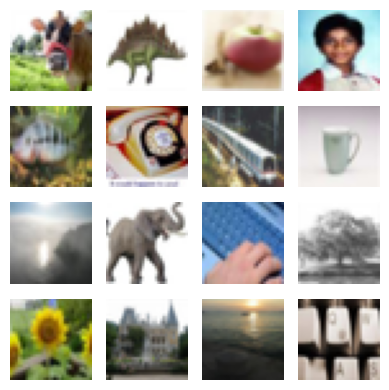

In [2]:
# Load the CIFAR dataset
CIFAR_train_set = CIFAR100(root=DATASET_PATH, train=True, download=True, transform=transforms.ToTensor())
CIFAR_test_set = CIFAR100(root=DATASET_PATH, train=False, download=True, transform=transforms.ToTensor())

# TODO: Visualise some images in a grid
def show_images(images, num_images=16, images_per_row=4):
    num_rows = (num_images + images_per_row - 1) // images_per_row
    plt.figure(figsize=(4, 4))

    for i in range(min(num_images, len(images))):
        if isinstance(images, torch.utils.data.Dataset):
            image, _ = images[i]
        else:
            image = images[i]

        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))

        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images(CIFAR_train_set, num_images=16, images_per_row=4)

Prepare the dataset in the training, validation and test split as mentioned before. The torchvision package gives us the training and test set as two separate dataset objects. Merge the original training and test set, and then create the new train-val-test split

In [3]:
# Merging original training and test set
CIFAR_all_images = np.concatenate([CIFAR_train_set.data, CIFAR_test_set.data], axis=0)
CIFAR_all_targets = torch.LongTensor(CIFAR_train_set.targets + CIFAR_test_set.targets)

Define our own, dataset class below.
It needs to:

- Take a set of images, labels/targets, and image transformations
- Return the corresponding images and labels element-wise.

In [4]:
class ImageDataset(data.Dataset):

    def __init__(self, imgs, targets, img_transform=None):
        """
        Inputs:
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        # TODO: Fill this
        img = self.imgs[idx]
        target = self.targets[idx]

        if self.img_transform is not None:
            img = self.img_transform(img)

        return img, target


    def __len__(self):
        # TODO: Fill this
        return len(self.imgs)


Create the class splits. Assign the classes randomly to training, validation and test, and use a 80%-10%-10% split.

In [5]:
classes = torch.randperm(100)  # Returns random permutation of numbers 0 to 99
train_classes, val_classes, test_classes = classes[:80], classes[80:90], classes[90:]

Classes have quite some variety and some classes might be easier to distinguish than others.

We want to learn the classification of those ten classes from 80 other classes in our training set, and few examples from the actual test classes.


You need to experiment with different number of examples per class.

Create the training, validation and test dataset according to our split above. For this, we create dataset objects of our previously defined class `ImageDataset`.

In [6]:
def dataset_from_labels(imgs, targets, class_set, img_transform):
    # TODO: Return an ImageDataset object representing a train / val / test set.
    # Its should use the set of all CIFAR images, targets and class split calculated above with the 80-10-10 rule.
    class_set = list(set(class_set))

    indices = [i for i, t in enumerate(targets) if int(t) in class_set]

    filtered_imgs = imgs[indices]
    filtered_targets = targets[indices]

    return ImageDataset(filtered_imgs, filtered_targets, img_transform)

In [7]:
# Pre-computed statistics from the new train set
DATA_MEANS = torch.Tensor([0.5183975 , 0.49192241, 0.44651328])
DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         DATA_MEANS, DATA_STD)
                                     ])
# For training, try adding some augmentations as well.
train_transform = transforms.Compose([ # TODO: Fill This #
                                      transforms.ToPILImage(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomRotation(15),
                                      transforms.RandomGrayscale(p=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD),
                                      ])

train_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, train_classes, img_transform=train_transform)
val_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, val_classes, img_transform=test_transform)
test_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, test_classes, img_transform=test_transform)

# Few-Shot Sampler (3p)

## The Core Concept

Prototypical Networks simulate few-shot learning during training by:

1. Randomly selecting N classes (N-way classification)
2. Sampling K examples per class for the **support set** (K-shot learning)
3. Sampling additional examples from the same classes for the **query set**

The model learns to classify query examples by comparing them to class prototypes computed from the support set.

## Implementation Task

Complete the `FewShotBatchSampler` class to:
- Select random classes for each episode
- Create support and query sets from these classes
- Ensure proper indexing for the dataloader

This sampler will enable the N-way, K-shot training regime needed for few-shot learning.

**Hint:** Refer to PyTorch's [Sampler documentation](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) for implementation details. You'll create a custom sampler that controls which data examples are used in each training batch.

In [8]:
class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels from the dataset in the order they occur in it.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        random.shuffle(self.class_list)

    def __iter__(self):
        # Todo: Fill this using the above code and the following directives #
        # Step 1) Shuffle data
        # Step 2) Sample few-shot batches.
        # Step 3) Select N classes for the batch
        # Step 4) For each class, select the next K examples and add them to the batch
        # Step 5) Take into account the self.include_query variable and return support+query set, if True.

        if self.shuffle:
            self.shuffle_data()
        class_counters = {c: 0 for c in self.classes}

        for it in range(self.iterations):
            batch = []
            support_inds = []
            query_inds = []

            subset = self.class_list[it * self.N_way:(it + 1) * self.N_way]

            for c in subset:
                counter = class_counters[c]
                start = counter * self.K_shot
                end = start + self.K_shot
                inds = self.indices_per_class[c][start:end].tolist()

                if self.include_query:
                    half = self.K_shot // 2
                    support_inds.extend(inds[:half])
                    query_inds.extend(inds[half:])
                else:
                    batch.extend(inds)

                class_counters[c] += 1

            if self.include_query:
                batch = support_inds + query_inds

            yield batch

    def __len__(self):
        return self.iterations

Now, create our intended data loaders by passing an object of `FewShotBatchSampler` as `batch_sampler=...` input to the PyTorch data loader object.

## Configuring Data Loaders

Use a 5-class 4-shot training setting:
- **N-way**: 5 classes per episode
- **K-shot**: 4 examples per class for the support set
- **Total support set size**: 20 images (5 × 4)

This configuration means each support set contains examples from 5 random classes with 4 examples per class. While it's usually best to match the training shots with your test configuration, we're using 4 as a compromise to allow for experimenting with different shot numbers later.

For optimal performance, you could treat the number of training shots as a hyperparameter in a grid search, but 4 shots works well for this exercise.

In [9]:
N_WAY = 5
K_SHOT = 4
train_data_loader = data.DataLoader(train_set,
                                    batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                      include_query=True,
                                                                      N_way=N_WAY,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=True),
                                    num_workers=4)
val_data_loader = data.DataLoader(val_set,
                                  batch_sampler=FewShotBatchSampler(val_set.targets,
                                                                    include_query=True,
                                                                    N_way=N_WAY,
                                                                    K_shot=K_SHOT,
                                                                    shuffle=False,
                                                                    shuffle_once=True),
                                  num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


The sampling of a support and query set should be implemented as sampling method from a support set with twice the number of examples, as shown below:

In [10]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

Finally, to ensure that our implementation of the data sampling process is correct, we can sample a batch and visualize its support and query set. What we would like to see is that the support and query set have the same classes, but distinct examples.

Support images


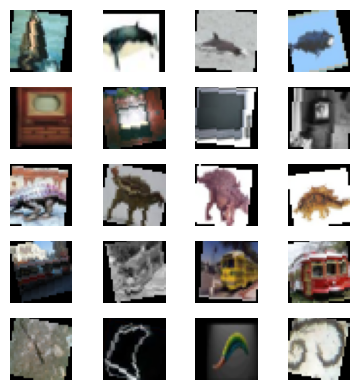


Query images


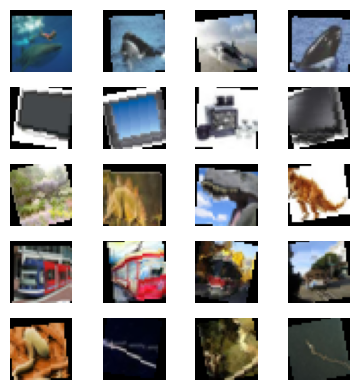

In [11]:
# Todo: Fill this #

def denormalize(imgs, mean, std):
    return imgs * std + mean

batch_imgs, batch_targets = next(iter(train_data_loader))
support_imgs, query_imgs, support_targets, query_targets = split_batch(batch_imgs, batch_targets)

assert support_imgs.shape[0] == N_WAY * K_SHOT
assert query_imgs.shape[0] == N_WAY * K_SHOT
assert support_targets.tolist() == query_targets.tolist()

mean_data = DATA_MEANS.view(1, 3, 1, 1)
std_data = DATA_STD.view(1, 3, 1, 1)
support_imgs = denormalize(support_imgs, mean_data, std_data)
query_imgs = denormalize(query_imgs, mean_data, std_data)

print("Support images")
show_images(support_imgs, num_images=20)
print("\nQuery images")
show_images(query_imgs, num_images=20)

# Prototypical Networks

The Prototypical Network, or ProtoNet for short, is a metric-based meta-learning algorithm that operates similarly to the nearest neighbor classification. Metric-based meta-learning methods classify a new example $\mathbf{x}$ based on some distance function $d_{\varphi}$ between $x$ and all elements in the support set. ProtoNets implements this idea with the concept of prototypes in a learned feature space. First, ProtoNet uses an embedding function $f_{\theta}$ to encode each input in the support set into a $L$-dimensional feature vector. Next, for each class $c$, we collect the feature vectors of all examples with label $c$ and average their feature vectors. Formally, we can define this as:

$$\mathbf{v}_c=\frac{1}{|S_c|}\sum_{(\mathbf{x}_i,y_i)\in S_c}f_{\theta}(\mathbf{x}_i)$$

where $S_c$ is the part of the support set $S$ for which $y_i=c$, and $\mathbf{v}_c$ represents the _prototype_ of class $c$. The prototype calculation is visualized below for a 2-dimensional feature space and 3 classes. The colored dots represent encoded support elements with the color-corresponding class labels, and the black dots next to the class label are the averaged prototypes.

protonet_classification.svg
---
Based on these prototypes, we want to classify a new example. Remember that since we want to learn the encoding function $f_{\theta}$, this classification must be differentiable, and hence, we need to define a probability distribution across classes. For this, we will make use of the distance function $d_{\varphi}$: the closer a new example $\mathbf{x}$ is to a prototype $\mathbf{v}_c$, the higher the probability for $\mathbf{x}$ belonging to class $c$. Formally, we can simply use a softmax over the distances of $\mathbf{x}$ to all class prototypes:

$$p(y=c\vert\mathbf{x})=\text{softmax}(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c))=\frac{\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c)\right)}{\sum_{c'\in \mathcal{C}}\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_{c'})\right)}$$

Note that the negative sign is necessary since we want to increase the probability for close-by vectors and have a low probability for distant vectors. We train the network $f_{\theta}$ based on the cross-entropy error of the training query set examples. Thereby, the gradient flows through both the prototypes $\mathbf{v}_c$ and the query set encodings $f_{\theta}(\mathbf{x})$. For the distance function $d_{\varphi}$, we can choose any function as long as it is differentiable concerning both of its inputs. The most common function, which we also use here, is the squared euclidean distance, but feel free to add your own suggestions!

Define the encoder function $f_{\theta}$, for our purposes it will be a DenseNet (use torchvision for this).

You should use common hyperparameters of 64 initial feature channels, add 32 per block, and use a bottleneck size of 64 (i.e. 2 times the growth rate).
We use 4 stages of 6 layers each, which results in overall about 1 million parameters.

Note that the torchvision package assumes that the last layer is used for classification and hence calls its output size `num_classes`.

However, we can instead just use it as the feature space of ProtoNet and choose an arbitrary dimensionality.

In [12]:
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(  # TODO: Fill this according to the instructions above
                                          num_init_features=64,
                                          growth_rate=32,
                                          bn_size=2,
                                          block_config=(6, 6, 6, 6),
                                          num_classes=output_size,
                                          memory_efficient=False
                                          )

    feat_dim = convnet.classifier.in_features
    convnet.classifier = nn.Linear(feat_dim, output_size)

    return convnet

# Advanced Techniques for Robust Few-Shot Learning

We will add two important enhancements to our ProtoNet implementation to boost its robustness and adaptability to new domains:

## CORAL Loss for Feature Alignment (1p)

When facing domain shifts between training and testing distributions, features can exhibit different statistical properties. The CORAL (CORrelation ALignment) loss aligns the second-order statistics (covariance) between support and query features, encouraging domain-invariant representations.

Implementation benefits:
- Reduces the impact of domain shift
- Improves generalization to new domains
- Creates more transferable features

Reference: [Deep CORAL: Correlation Alignment for Deep Domain Adaptation](https://arxiv.org/abs/1607.01719)


In [13]:
def coral_loss(source, target):
    # TODO: Fill this

    embedding_dim = source.size(1)
    batch_size = source.size(0)

    source_mean = torch.mean(source, dim=0, keepdim=True)
    source_cov = (source - source_mean).T @ (source - source_mean) / (batch_size - 1)

    target_mean = torch.mean(target, dim=0, keepdim=True)
    target_cov = (target - target_mean).T @ (target - target_mean) / (batch_size - 1)

    diff = source_cov - target_cov
    loss = torch.mean(diff ** 2)

    return loss

## Auxiliary Discrimination Branch (1p)

To enhance feature discrimination, we'll add an auxiliary branch that classifies whether features come from the support or query set. This branch:
- Acts as a regularizer for the feature extractor
- Encourages the network to learn domain-aware features
- Provides additional supervision signals during training

You can experiment with the architecture of this branch to find the optimal configuration for your specific few-shot learning task.

In [14]:
# TODO: Implement the Auxiliary Discrimination Branch inside the ProtoNet class #

Next, implement ProtoNet.
The first step during training is to encode all images in a batch with our network.
Next, we calculate the class prototypes from the support set (function `calculate_prototypes`), and classify the query set examples according to the prototypes (function `classify_feats`).
Keep in mind that we use the data sampling described before, such that the support and query set are stacked together in the batch.
Thus, we use our previously defined function `split_batch` to split them apart.

In [15]:
class ProtoNet(nn.Module):
    def __init__(self, proto_dim, lr):
        """
        Inputs:
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of Adam optimizer
        """
        super(ProtoNet, self).__init__()
        self.proto_dim = proto_dim
        self.lr = lr
        self.model = get_convnet(output_size=proto_dim)
        self.optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[140, 180], gamma=0.1)

        # --- Auxiliary Branch for Discrimination Loss --- #
        # This branch predicts whether a feature comes from the support (0) or query (1) set.
        self.aux_classifier = nn.Sequential(
            nn.Linear(proto_dim, proto_dim),
            nn.BatchNorm1d(proto_dim),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(proto_dim, proto_dim // 2),
            nn.BatchNorm1d(proto_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(proto_dim // 2, 2)
        )
        self.lambda_aux = 0.1
        self.lambda_coral = 1

    @staticmethod
    def calculate_prototypes(features, targets):
        # TODO: Fill this, remember to average class feature vectors during the calculation of prototypes

        prototypes = []
        classes = torch.unique(targets)
        for c in classes:
            mask = targets == c
            prot = features[mask].mean(dim=0)
            prototypes.append(prot)

        prototypes = torch.stack(prototypes, dim=0)
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # TODO: Fill this using squared euclidean as your distance.

        distances = torch.cdist(feats, prototypes, p=2).pow(2)
        logits = -distances

        preds = torch.argmax(logits, dim=1)

        class_to_idx = {c.item(): i for i, c in enumerate(classes)}
        labels = torch.tensor([class_to_idx[t.item()] for t in targets]).to(preds.device)

        acc = (preds == labels).float().mean()

        return preds, labels, acc

    def forward(self, imgs):
        features = self.model(imgs)
        return features

    def calculate_loss(self, features, targets):
        # TODO: Fill this

        support_features, query_features, support_targets, query_targets = split_batch(features, targets)

        prototypes, classes = self.calculate_prototypes(support_features, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_features, query_targets)

        ce_loss = F.cross_entropy(-torch.cdist(query_features, prototypes, p=2).pow(2), labels)

        domain_labels = torch.cat([
            torch.zeros(support_features.size(0), dtype=torch.long),
            torch.ones(query_features.size(0), dtype=torch.long)
        ]).to(features.device)

        all_feats = torch.cat([support_features, query_features], dim=0)
        domain_logits = self.aux_classifier(all_feats)
        aux_loss = F.cross_entropy(domain_logits, domain_labels)

        cor_loss = coral_loss(support_features, query_features)

        loss = ce_loss + self.lambda_aux * aux_loss + self.lambda_coral * cor_loss

        return loss, acc

### Training and Validation (2p)

We recommend training for about 20 epochs and with a 64-dimensional feature space.

In [16]:
def train_model(model_class, train_loader, val_loader, proto_dim, lr, max_epochs=20, **kwargs):
    # Initialize the model
    model = model_class(proto_dim=proto_dim, lr=lr)
    model.to(device)

    # Train the model, validate every epoch and keep the best model.
    # Todo: Fill this #

    best_acc = 0.0
    best_state = None

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_train_loss = 0.0
        total_train_acc = 0.0
        train_count = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)

            features = model(imgs)
            loss, acc = model.calculate_loss(features, targets)

            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()
            total_train_loss += loss.item()
            total_train_acc += acc
            train_count += 1

        avg_train_loss = total_train_loss / train_count if train_count > 0 else 0
        avg_train_acc = total_train_acc / train_count if train_count > 0 else 0
        model.scheduler.step()

        model.eval()
        val_acc = 0.0
        val_count = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)

                features = model(imgs)
                _, acc = model.calculate_loss(features, targets)

                val_acc += acc
                val_count += 1

        avg_val_acc = val_acc / val_count if val_count > 0 else 0
        print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Train Acc={avg_train_acc:.4f} | Val Acc={avg_val_acc:.4f}")

        if avg_val_acc > best_acc:
            best_acc = avg_val_acc
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    return model

In [17]:
protonet_model = train_model(ProtoNet,
                             proto_dim=64,
                             lr=2e-4,
                             train_loader=train_data_loader,
                             val_loader=val_data_loader)

Epoch 1: Train Loss=1.5883, Train Acc=0.3600 | Val Acc=0.5607
Epoch 2: Train Loss=1.4582, Train Acc=0.4174 | Val Acc=0.5930
Epoch 3: Train Loss=1.4023, Train Acc=0.4419 | Val Acc=0.6110
Epoch 4: Train Loss=1.3773, Train Acc=0.4594 | Val Acc=0.5977
Epoch 5: Train Loss=1.3420, Train Acc=0.4756 | Val Acc=0.6050
Epoch 6: Train Loss=1.3112, Train Acc=0.4901 | Val Acc=0.6353
Epoch 7: Train Loss=1.2888, Train Acc=0.5055 | Val Acc=0.6367
Epoch 8: Train Loss=1.2697, Train Acc=0.5161 | Val Acc=0.6257
Epoch 9: Train Loss=1.2405, Train Acc=0.5281 | Val Acc=0.6677
Epoch 10: Train Loss=1.2091, Train Acc=0.5433 | Val Acc=0.6523
Epoch 11: Train Loss=1.1821, Train Acc=0.5539 | Val Acc=0.6757
Epoch 12: Train Loss=1.1653, Train Acc=0.5645 | Val Acc=0.6893
Epoch 13: Train Loss=1.1433, Train Acc=0.5765 | Val Acc=0.6960
Epoch 14: Train Loss=1.1244, Train Acc=0.5775 | Val Acc=0.6833
Epoch 15: Train Loss=1.1198, Train Acc=0.5831 | Val Acc=0.7007
Epoch 16: Train Loss=1.0955, Train Acc=0.5974 | Val Acc=0.7007
E

### Testing (1p)

Our goal of meta-learning is to obtain a model that can quickly adapt to a new task, or in this case, new classes to distinguish between. To test this, we will use our trained ProtoNet and adapt it to the 10 test classes. Thereby, we pick $k$ examples per class from which we determine the prototypes and test the classification accuracy on all other examples. This can be seen as using the $k$ examples per class as a support set, and the rest of the dataset as a query set. We iterate through the dataset such that each example has been once included in a support set. The average performance across all support sets tells us how well we can expect ProtoNet to perform when seeing only $k$ examples per class. During training, we used $k=4$. In testing, we will experiment with $k=\{2,4,8,16,32\}$ to get a better sense of how $k$ influences the results. We would expect that we achieve higher accuracies the more examples we have in the support set, but we don't know how it scales. Hence, let's first implement a function that executes the testing procedure for a given $k$:

In [18]:
@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    """
    Inputs
        model - Pretrained ProtoNet model
        dataset - The dataset on which the test should be performed.
                  Should be instance of ImageDataset
        data_feats - The encoded features of all images in the dataset.
                     If None, they will be newly calculated, and returned
                     for later usage.
        k_shot - Number of examples per class in the support set.
        The encoder network remains unchanged across k-shot settings. Hence, we only need to extract the features for all images once.
    """
    model = model.to(device)
    model.eval()
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes  # We assume uniform example distribution here


    if data_feats is None:


        # TODO: Extract features and targets #
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # ... #

        loader = data.DataLoader(dataset, batch_size=64, shuffle=False)
        all_features, all_targets = [], []

        for imgs, targets in loader:
            imgs, targets = imgs.to(device), targets.to(device)
            feats = model(imgs)
            all_features.append(feats)
            all_targets.append(targets)

        img_features = torch.cat(all_features, dim=0)
        img_targets = torch.cat(all_targets, dim=0)

        sorted_idx = torch.argsort(img_targets)
        img_features = img_features[sorted_idx].view(num_classes, exmps_per_class, -1)
        img_targets = img_targets[sorted_idx].view(num_classes, exmps_per_class)
        unique_classes = torch.sort(img_targets[:, 0]).values

    else:
        img_features, img_targets = data_feats
        unique_classes = torch.sort(img_targets[:, 0]).values

    # We iterate through the full dataset in two manners.
    # First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples

    feat_dim = img_features.shape[2]
    accuracies = []
    for k_idx in range(0, exmps_per_class, k_shot):


        # Select support set and calculate prototypes

        # TODO: Fill this #

        support_feats = img_features[:, k_idx:k_idx + k_shot, :]
        prototypes = support_feats.mean(dim=1)

        # Evaluate accuracy on the rest of the dataset #
        batch_acc = 0.0
        num_queries = 0
        for e_idx in range(0, exmps_per_class, k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue

            #  TODO: Fill this #

            q_feats = img_features[:, e_idx:e_idx + k_shot, :].reshape(-1, feat_dim)
            q_labels = img_targets[:, e_idx:e_idx + k_shot].reshape(-1)

            distances = torch.cdist(q_feats, prototypes)
            pred_indices = torch.argmin(distances, dim=1)

            pred_classes = unique_classes[pred_indices]

            batch_acc += (pred_classes == q_labels).float().mean().item()
            num_queries += 1

        accuracies.append(batch_acc / num_queries)

    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

Testing ProtoNet is relatively quick if we have processed all images once. Hence, we can do in this notebook:

In [19]:
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, test_set, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protonet_accuracies[k][0]:4.2f}% (+-{100*protonet_accuracies[k][1]:4.2f}%)")

Accuracy for k=2: 35.75% (+-3.26%)
Accuracy for k=4: 41.46% (+-2.54%)
Accuracy for k=8: 45.70% (+-1.60%)
Accuracy for k=16: 48.43% (+-1.08%)
Accuracy for k=32: 49.84% (+-0.67%)


Plot the accuracies over number of examples in the support set:

In [20]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
    ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
    ax.set_xticks(ks)
    ax.set_xlim([ks[0]-1, ks[-1]+1])
    ax.set_xlabel("Number of shots per class", weight='bold')
    ax.set_ylabel("Accuracy", weight='bold')
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight='bold')
    else:
        ax.set_title(ax.get_title() + " and " + name, weight='bold')
    ax.legend()
    return ax

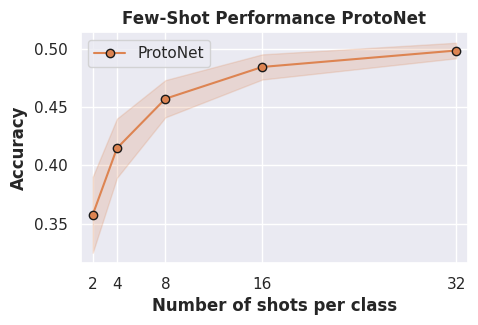

In [21]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()

# Domain adaptation in the SVHN (1p)

So far, we have evaluated our meta-learning algorithms on the same dataset on which we have trained them. However, meta-learning algorithms are especially interesting when we want to move from one to another dataset. So, what happens if we apply them on a quite different dataset than CIFAR?

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST by having the classes 0 to 9, but is more difficult due to its real-world setting and possible distracting numbers left and right. Let's first load the dataset, and visualize some images to get an impression of the dataset.

In [22]:
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=transforms.ToTensor())

100%|██████████| 64.3M/64.3M [00:11<00:00, 5.70MB/s]


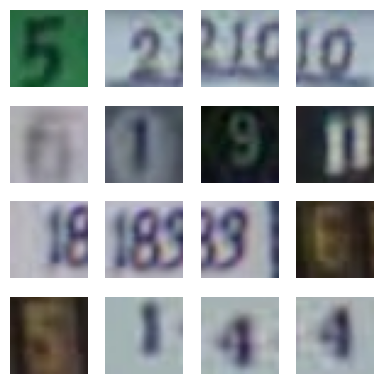

In [23]:
# Visualize some examples
# TODO: Fill this #
show_images(SVHN_test_dataset)

Each image is labeled with one class between 0 and 9 representing the main digit in the image. Can our ProtoNet learn to classify the digits from only a few examples? This is what we will test out below. The images have the same size as CIFAR, so that we can use the images without changes.

Prepare the dataset, for which we take the first 500 images per class. For this dataset, we use our test functions as before to get an estimated performance for different number of shots.

In [24]:
# TODO: Prepare the Dataset in an ImageDataset class, limit number of examples to 500 to reduce test time #
def svhn_dataset(dataset, examples_per_class=500):
    images = dataset.data.transpose(0, 2, 3, 1)
    labels = dataset.labels

    selected_indices = []
    class_counts = {i: 0 for i in range(10)}

    for idx, label in enumerate(labels):
        if class_counts[label] < examples_per_class:
            selected_indices.append(idx)
            class_counts[label] += 1

    svhn_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEANS, DATA_STD)
    ])

    return ImageDataset(
        imgs=images[selected_indices],
        targets=torch.LongTensor(labels[selected_indices]),
        img_transform=svhn_transform
    )

svhn_test = svhn_dataset(SVHN_test_dataset, examples_per_class=500)

### Experiments

First, we can apply ProtoNet to the SVHN dataset:

In [25]:
# TODO: Fill this #
protonet_svhn_accuracies = dict()
svhn_data_feats = None

for k in [2, 4, 8, 16, 32]:
    protonet_svhn_accuracies[k], svhn_data_feats = test_proto_net(
        protonet_model,
        svhn_test,
        data_feats=svhn_data_feats,
        k_shot=k
    )
    print(f"Accuracy for k={k}: {100.0*protonet_svhn_accuracies[k][0]:4.2f}% (+-{100*protonet_svhn_accuracies[k][1]:4.2f}%)")

Accuracy for k=2: 12.03% (+-1.10%)
Accuracy for k=4: 12.77% (+-1.00%)
Accuracy for k=8: 13.72% (+-0.94%)
Accuracy for k=16: 14.55% (+-1.07%)
Accuracy for k=32: 15.59% (+-0.75%)


It becomes clear that the results are much lower than the ones on CIFAR, and just slightly above random for $k=2$.

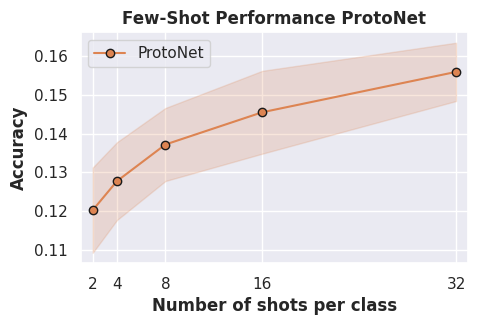

In [26]:
ax = plot_few_shot(protonet_svhn_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()

Repeat the experiments again by re-training on MNIST and testing on SVHN.
What do you expect in terms of performance?

In [27]:
# TODO: Fill this #
# Hint: Project MNIST to RGB by repeating 3 times the single grayscale channel #

classes = torch.randperm(10)
train_classes = classes[:7].tolist()
val_classes = classes[7:].tolist()

MNIST_MEANS = [0.1307, 0.1307, 0.1307]
MNIST_STD = [0.3081, 0.3081, 0.3081]

MNIST_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEANS, MNIST_STD),
])


MNIST_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEANS, MNIST_STD),
])

MNIST_train_set = MNIST(root=DATASET_PATH, train=True,  download=True, transform=transforms.ToTensor())
MNIST_test_set = MNIST(root=DATASET_PATH, train=False, download=True, transform=transforms.ToTensor())

MNIST_all_images = np.concatenate([MNIST_train_set.data.numpy(), MNIST_test_set.data.numpy()], axis=0)
MNIST_all_targets = torch.LongTensor(MNIST_train_set.targets.tolist() + MNIST_test_set.targets.tolist())

train_set = dataset_from_labels(MNIST_all_images, MNIST_all_targets, train_classes, img_transform=MNIST_train_transform)
val_set = dataset_from_labels(MNIST_all_images, MNIST_all_targets, val_classes, img_transform=MNIST_test_transform)

mnist_train_data_loader = data.DataLoader(train_set,
                                          batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                            include_query=True,
                                                                            N_way=N_WAY,
                                                                            K_shot=K_SHOT,
                                                                            shuffle=True),
                                          num_workers=4)
mnist_val_data_loader = data.DataLoader(val_set,
                                        batch_sampler=FewShotBatchSampler(val_set.targets,
                                                                          include_query=True,
                                                                          N_way=N_WAY,
                                                                          K_shot=K_SHOT,
                                                                          shuffle=False,
                                                                          shuffle_once=True),
                                        num_workers=4)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.46MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 57.2kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.10MB/s]


In [29]:
mnist_protonet_model = train_model(ProtoNet,
                                  proto_dim=64,
                                  lr=2e-4,
                                  train_loader=mnist_train_data_loader,
                                  val_loader=mnist_val_data_loader,
                                  max_epochs=10)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1: Train Loss=0.4962, Train Acc=0.8401 | Val Acc=0.8872
Epoch 2: Train Loss=0.2288, Train Acc=0.9501 | Val Acc=0.8613
Epoch 3: Train Loss=0.1802, Train Acc=0.9667 | Val Acc=0.8655
Epoch 4: Train Loss=0.1693, Train Acc=0.9705 | Val Acc=0.8763
Epoch 5: Train Loss=0.1582, Train Acc=0.9738 | Val Acc=0.8858
Epoch 6: Train Loss=0.1464, Train Acc=0.9783 | Val Acc=0.9097
Epoch 7: Train Loss=0.1423, Train Acc=0.9804 | Val Acc=0.9147
Epoch 8: Train Loss=0.1291, Train Acc=0.9842 | Val Acc=0.9125
Epoch 9: Train Loss=0.1281, Train Acc=0.9833 | Val Acc=0.8642
Epoch 10: Train Loss=0.1207, Train Acc=0.9857 | Val Acc=0.9141


In [30]:
mnist_protonet_svhn_accuracies = dict()
svhn_data_feats = None

for k in [2, 4, 8, 16, 32]:
    mnist_protonet_svhn_accuracies[k], svhn_data_feats = test_proto_net(
        mnist_protonet_model,
        svhn_test,
        data_feats=svhn_data_feats,
        k_shot=k
    )
    print(f"Accuracy for k={k}: {100.0*mnist_protonet_svhn_accuracies[k][0]:4.2f}% (+-{100*mnist_protonet_svhn_accuracies[k][1]:4.2f}%)")

Accuracy for k=2: 11.65% (+-0.90%)
Accuracy for k=4: 12.11% (+-1.00%)
Accuracy for k=8: 12.84% (+-0.97%)
Accuracy for k=16: 13.67% (+-1.06%)
Accuracy for k=32: 14.39% (+-0.95%)


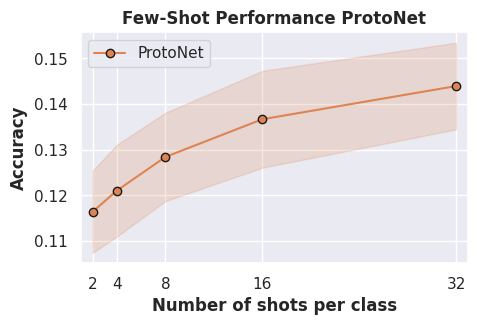

In [31]:
ax = plot_few_shot(mnist_protonet_svhn_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()